In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import glob
import pprint
import copy
import shutil

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from collections import OrderedDict

from dataset import *
from runner import ExptRunner
from runner import ExptEvaluator
from networks.imageencoder import *
from networks.imagedecoder import *
from networks.DenseAutoEncoder import DenseAutoEncoder
from networks.composedautoencoder import ComposedAutoEncoder
from networks.ConvVae import ConvVae
from networks.vae import VAE
from networks.dense import *
from networks.lossfunctions import *
from networks.reacherspecial import *
from helpers import *
import utils
import simplereacherdimensions
import simplereacheradapters
from env.simulator import simulator, evaluator

In [3]:
import warnings
warnings.filterwarnings("ignore", category=torch.serialization.SourceChangeWarning)

In [4]:
opt = np.get_printoptions()
np.set_printoptions(threshold=np.inf)

In [5]:
torch.set_printoptions(sci_mode=False)

In [6]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [7]:
print (device)

cuda:2


In [8]:
if torch.cuda.is_available():
    print (torch.cuda.current_device())
    torch.cuda.set_device(device)
    print (torch.cuda.current_device())

0
2


In [9]:
root_folder = 'data/simple_reacher/training'
# number_of_trajectories = 10
number_of_trajectories = 5000

In [10]:
start = time.time()
train_data = SimpleReacherOnDemandDataset(root_folder, range(4750), device=device)
test_data = SimpleReacherOnDemandDataset(root_folder, range(4750, 5000), device=device)
print ("Time Taken: {} sec".format(time.time() - start))

Time Taken: 7.540468692779541 sec


In [11]:
print (len(train_data))
print (len(test_data))
print (train_data.trajectory_data.device)
print (test_data.trajectory_data.device)

103274
5399
cuda:2
cuda:2


In [12]:
def run_expts(train_epochs):
    for i in range(len(expts)):
        arg_lists = expts[i]
        cons_args = arg_lists[0]
        train_args = {}
        if (len(arg_lists)) > 1:
            train_args = arg_lists[1]
        test_args = {}
        if (len(arg_lists)) > 2:
            test_args = arg_lists[2]
        
        runner = ExptRunner(train_data=train_data, test_data=test_data, device=device, **cons_args)
        print ("Experiment logs folder: {}".format(runner.log_folder))
        with open(runner.log_folder + '/expt.txt', 'w') as f:
            f.write(pprint.pformat(arg_lists))
        runner.train(train_epochs, **train_args)

In [13]:
# First number represents the number of layers, second : channels per each layer, third : kernel size
img_auto_encoder = lambda: ComposedAutoEncoder(x_dim=simplereacherdimensions.x_dim,
                                               img_res=simplereacherdimensions.img_res,
                                               layers_channels=[16, 16, 16, 16],
                                               useMaxPool=True,
                                               device=device)

img_auto_encoder_5_16_7 = lambda: ComposedAutoEncoder(x_dim=simplereacherdimensions.x_dim,
                                               img_res=simplereacherdimensions.img_res,
                                               layers_channels=[16, 16, 16, 16, 16],
                                               useMaxPool=True,
                                               device=device,
                                               kernel_size=7)

img_auto_encoder_5_32_7 = lambda: ComposedAutoEncoder(x_dim=simplereacherdimensions.x_dim,
                                               img_res=simplereacherdimensions.img_res,
                                               layers_channels=[32, 32, 32, 32, 32],
                                               useMaxPool=True,
                                               device=device,
                                               kernel_size=7)
img_auto_encoder_5_16_5 = lambda: ComposedAutoEncoder(x_dim=simplereacherdimensions.x_dim,
                                               img_res=simplereacherdimensions.img_res,
                                               layers_channels=[16, 16, 16, 16, 16],
                                               useMaxPool=True,
                                               device=device,
                                               kernel_size=5)

img_auto_encoder_5_32_5 = lambda: ComposedAutoEncoder(x_dim=simplereacherdimensions.x_dim,
                                               img_res=simplereacherdimensions.img_res,
                                               layers_channels=[32, 32, 32, 32, 32],
                                               useMaxPool=True,
                                               device=device,
                                               kernel_size=5)
img_encoder_5_32_5 = lambda: ImageEncoderFlatInput(img_res=simplereacherdimensions.img_res,
                                               input_channels=1,
                                               layers_channels=[32, 32, 32, 32, 32],
                                               prefix='enc',
                                               useMaxPool=True,
                                               addFlatten=True,
                                               kernel_size=5)

In [14]:
def load_pretrained(folder):
    chkptFile = os.path.join('runs', folder, 'train_checkpoint.tar')
    return torch.load(chkptFile, map_location=device)['model']

pretrain_image_auto_enc = load_pretrained('08-13/run2-img-auto-encoder/08-13-21-59-10-ImageAutoEncoder-Reacher-ComposedAutoEncoder_5_32_5-L1')
pretrain_policy = load_pretrained('08-11/run1-policy/08-11-15-45-41-Policy-Reacher-Dense4WithTanh-mse')
pretrain_img_to_env = load_pretrained('08-12/run1-img-to-env/08-12-18-44-36-ImageToEnv-Reacher-Conv4Dense3-MSE/')

In [15]:
img_layers = [16,16,16,16]
# z_dim = 4096 # 16 * 26 * 16 , This should be set based on above img_layers
z_dim = 2048
env_layers = [6, 256, z_dim]
in_channels = 1
img_encoder = lambda: ImageEncoderFlatInput(in_channels, img_layers, 'imgenc', useMaxPool=True, addFlatten=True, img_res=simplereacheradapters.img_res)
# img_decoder = lambda: ImageDecoderFlatInput(z_dim, list(reversed(img_layers)), in_channels, 'imgdec', useSigmoid=True)
# env_encoder = lambda: Dense(env_layers, use_last_act=False, prefix='envenc')
env_decoder = lambda: Dense(list(reversed(env_layers)), last_act='sigmoid', prefix='envdec')
combined = lambda l1, l2: nn.Sequential(OrderedDict([
                              ('EncNet', l1()),
                              ('DecNet', l2()),
                            ]))

In [16]:
def env_enc_pretrained_img_dec():
    net = combined(env_encoder, img_decoder).to(device)
    load_mapped_state_dict(net, pretrain_imgEncDec, 'DecNet.net.imgdec', 'decoder.net.dec')
    return net

def pretrained_img_enc_env_dec(i_encoder, e_decoder):
    net = combined(i_encoder, e_decoder).to(device)
    load_mapped_state_dict(net, pretrain_image_auto_enc, 'EncNet.net.imgenc', 'encoder.net.enc')
    return net

def img_enc_env_dec_from_pretrained():
    net = combined(img_encoder, env_decoder).to(device)
    load_mapped_state_dict(net, pretrain_imgEncDec, 'EncNet.net.imgenc', 'encoder.net.enc')
    load_mapped_state_dict(net, pretrain_envEncDec, 'DecNet.net.envdec_fc0', 'decoder.dec_fc1') # Hacky
    return net

def latent_policy_from_latent(latentReference, policy=None, fix_indices=[0]):
    latent = copy.deepcopy(latentReference)
    if not policy:
        policy = Dense(layer_dims=[6, 16, 16, 3], last_act='tanh', prefix='pol')
    configure_net_training(latent, False)
    net = LatentPolicyNet(latent=latent, policy=policy).to(device)
    return net

def latent_policy_fixed_img_enc_pol_train_env_dec(latentFilter=None, policy=pretrain_policy, e_decoder=env_decoder, i_encoder=img_encoder):
    latent = pretrained_img_enc_env_dec(i_encoder, e_decoder)
    policy = copy.deepcopy(policy)
    configure_net_training(policy, False)
    configure_net_training(latent[0], False)
    return LatentPolicyNet(latent=latent, policy=policy, latentFilter=latentFilter).to(device)

def latentFilter_gt_x_latent_y(data, latent_output):
    return torch.cat((Xt_scaled_adapter(data), latent_output[:, 2:]), dim=1)

def image_to_env(conv, dense):
    return combined(conv, dense)

In [79]:
pretrain_image_auto_enc.state_dict().keys()

odict_keys(['encoder.net.enc_conv0.weight', 'encoder.net.enc_conv0.bias', 'encoder.net.enc_conv1.weight', 'encoder.net.enc_conv1.bias', 'encoder.net.enc_conv2.weight', 'encoder.net.enc_conv2.bias', 'encoder.net.enc_conv3.weight', 'encoder.net.enc_conv3.bias', 'encoder.net.enc_conv4.weight', 'encoder.net.enc_conv4.bias', 'decoder.net.dec_convt0.weight', 'decoder.net.dec_convt0.bias', 'decoder.net.dec_convt1.weight', 'decoder.net.dec_convt1.bias', 'decoder.net.dec_convt2.weight', 'decoder.net.dec_convt2.bias', 'decoder.net.dec_convt3.weight', 'decoder.net.dec_convt3.bias', 'decoder.net.dec_convt4.weight', 'decoder.net.dec_convt4.bias'])

In [80]:
net = combined(img_encoder, env_decoder).to(device)
net.state_dict().keys()

odict_keys(['EncNet.net.imgenc_conv0.weight', 'EncNet.net.imgenc_conv0.bias', 'EncNet.net.imgenc_conv1.weight', 'EncNet.net.imgenc_conv1.bias', 'EncNet.net.imgenc_conv2.weight', 'EncNet.net.imgenc_conv2.bias', 'EncNet.net.imgenc_conv3.weight', 'EncNet.net.imgenc_conv3.bias', 'DecNet.net.envdec_fc0.weight', 'DecNet.net.envdec_fc0.bias', 'DecNet.net.envdec_fc1.weight', 'DecNet.net.envdec_fc1.bias'])

In [81]:
net = latent_policy_fixed_img_enc_pol_train_env_dec(i_encoder=img_encoder_5_32_5)

In [82]:
r = verify_mapped_state_dict(net, pretrain_image_auto_enc, 'EncNet.net.imgenc', 'encoder.net.enc')
if not r:
    print ('Verificiation failed!')

In [87]:
sample = train_data[1]['images'] / 255.0
print (sample.size())
print (net.latent[0](sample).size())
print (net(sample).size())

torch.Size([65536])
torch.Size([1, 2048])
torch.Size([1, 3])


In [85]:
net

LatentPolicyNet(
  (latent): Sequential(
    (EncNet): ImageEncoderFlatInput(
      (net): Sequential(
        (enc_conv0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (enc_relu0): ReLU()
        (enc_maxpool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (enc_conv1): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (enc_relu1): ReLU()
        (enc_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (enc_conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (enc_relu2): ReLU()
        (enc_maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (enc_conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (enc_relu3): ReLU()
        (enc_maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (enc_conv4): Conv2d(32, 32, kernel

In [57]:
pretrain_image_auto_enc

ComposedAutoEncoder(
  (encoder): ImageEncoder(
    (net): Sequential(
      (enc_conv0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (enc_relu0): ReLU()
      (enc_maxpool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (enc_conv1): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (enc_relu1): ReLU()
      (enc_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (enc_conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (enc_relu2): ReLU()
      (enc_maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (enc_conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (enc_relu3): ReLU()
      (enc_maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (enc_conv4): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (enc_re

In [23]:
expts = [
#   Fixed image encoder, policy, train decoder from encoder output to policy input
#     [{
#         "expt_prefix":'FixImageEncoderPolicy_TrainDecoder-Reacher-Conv4Dense3-MSE',
#         "net_func": lambda: latent_policy_fixed_img_enc_pol_train_env_dec(i_encoder=img_encoder_5_32_5),
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": mse_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#   Train policy using fixed Image To Env function
#     [{
#         "expt_prefix":'FixImageToEnv_TrainFreshPolicy-Reacher-Conv4Dense3-MSE',
#         "net_func": lambda: latent_policy_from_latent(pretrain_img_to_env),
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": mse_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#   Image To Env function
#     [{
#         "expt_prefix":'ImageToEnv-Reacher-Conv4Dense3-MSE',
#         "net_func": lambda: image_to_env(img_encoder, env_decoder),
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.XtYt_scaled_adapter,
#         "loss_adapter_func": mse_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#   Policy
#     [{
#         "expt_prefix":'Policy-Reacher-Dense4WithTanh-L1',
#         "net_func": lambda: Dense(layer_dims=[6, 16, 16, 3], last_act='tanh', prefix='pol'),
#         "data_adapter_func": simplereacheradapters.XtYt_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#     [{
#         "expt_prefix":'Policy-Reacher-Dense4WithTanh-mse',
#         "net_func": lambda: Dense(layer_dims=[6, 16, 16, 3], last_act='tanh', prefix='pol'),
#         "data_adapter_func": simplereacheradapters.XtYt_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": mse_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
    [{
        "expt_prefix":'Policy-Reacher-Dense4WithSigmoid-L1',
        "net_func": lambda: Dense(layer_dims=[6, 16, 16, 3], last_act='sigmoid', prefix='pol'),
        "data_adapter_func": simplereacheradapters.XtYt_scaled_adapter,
        "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter,
        "loss_adapter_func": l1_loss_adapter,
     },
    {
    },
    {
        "loss_adapter": l1_loss_adapter
    }],
#   Image autoencoder
#     [{
#         "expt_prefix":'ImageAutoEncoder-Reacher-ComposedAutoEncoder4-MSE',
#         "net_func": img_auto_encoder,
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "loss_adapter_func": mse_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#     [{
#         "expt_prefix":'ImageAutoEncoder-Reacher-ComposedAutoEncoder4-L1',
#         "net_func": img_auto_encoder,
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#     [{
#         "expt_prefix":'ImageAutoEncoder-Reacher-ComposedAutoEncoder_5_16_7-L1',
#         "net_func": img_auto_encoder_5_16_7,
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#     [{
#         "expt_prefix":'ImageAutoEncoder-Reacher-ComposedAutoEncoder_5_32_7-L1',
#         "net_func": img_auto_encoder_5_32_7,
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#     [{
#         "expt_prefix":'ImageAutoEncoder-Reacher-ComposedAutoEncoder_5_16_5-L1',
#         "net_func": img_auto_encoder_5_16_5,
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#     [{
#         "expt_prefix":'ImageAutoEncoder-Reacher-ComposedAutoEncoder_5_32_5-L1',
#         "net_func": img_auto_encoder_5_32_5,
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
]

In [24]:
train_epochs = 100
run_expts(train_epochs)

Experiment logs folder: runs/08-17-14-49-24-Policy-Reacher-Dense4WithSigmoid-L1


In [25]:
start = time.time()

for chkpt_file in utils.enumerate_files(rootdir='runs/08-17/run1-policy/08-17-14-49-24-Policy-Reacher-Dense4WithSigmoid-L1'):
    e = ExptEvaluator(chkpt_file, train_data, test_data, device)
    e.test()
    print ('Done with checkpoint file {}'.format(chkpt_file))

print ("Time Taken: {} sec".format(time.time() - start))

Done with checkpoint file runs/08-17/run1-policy/08-17-14-49-24-Policy-Reacher-Dense4WithSigmoid-L1/train_checkpoint.tar
Time Taken: 91.05693697929382 sec


In [68]:
def save_sample(ip_batch, op_batch, filePath):
    cmap = plt.get_cmap('gray')
    ip_batch = ip_batch.cpu()
    op_batch = op_batch.cpu()
    fig = plt.figure()
    ax = plt.subplot(1, 2, 1)
    plt.imshow(ip_batch.reshape(256, 256), cmap=cmap, vmin=0, vmax=1)
    ax.title.set_text('Original')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax = plt.subplot(1, 2, 2)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.imshow(op_batch.reshape(256, 256), cmap=cmap, vmin=0, vmax=1)
    ax.title.set_text('Recontructed')
    fig.savefig(filePath)
    plt.close()

In [69]:
start = time.time()

for chkpt_file in utils.enumerate_files(rootdir='runs/08-13/run2-img-auto-encoder/'):
    chkpt = torch.load(chkpt_file, map_location=device)
    net = chkpt['model']
    data_adapter_func = chkpt['input_adapter']
    # data_to_label_adapter = chkpt['label_adapter']
    log_folder = os.path.dirname(chkpt_file)
    for dataset, setName in zip([train_data, test_data], ['training_set', 'test_set']):
        for crit in ['good', 'bad']:
            with open(os.path.join(log_folder, '{}_{}_samples.txt'.format(setName, crit)), 'r') as f:
                while True:
                    line = f.readline()
                    if len(line) == 0:
                        break
                    idx = int(line)
                    ip_batch = data_adapter_func(dataset[idx])
                    with torch.no_grad():
                        op_batch = net(ip_batch)
                        save_sample(ip_batch, op_batch, os.path.join(log_folder, '{}_{}_{}.png'.format(setName, crit, idx)))

print ("Time Taken: {} sec".format(time.time() - start))

Time Taken: 2.773077964782715 sec


In [26]:
cpu = torch.device('cpu')
cpu

device(type='cpu')

In [27]:
start = time.time()
train_traj_data = SimpleReacherTrajectoryDataset(root_folder, range(500), device=cpu) #only a subset of training_data
test_traj_data = SimpleReacherTrajectoryDataset(root_folder, range(4750, 5000), device=cpu)
print ("Time Taken: {} sec".format(time.time() - start))

Time Taken: 0.00011420249938964844 sec


In [58]:
pretrained_net = nn.Sequential(OrderedDict([
                      ('ItoY', pretrain_img_to_env),
                      ('pol', pretrain_policy),
                    ])).to(cpu)
pretrained_net = pretrained_net.eval()

In [ ]:
start = time.time()

for chkpt_file in utils.enumerate_files(rootdir='runs/08-17/run1-policy/08-17-14-49-24-Policy-Reacher-Dense4WithSigmoid-L1'):
    print ('Start processing checkpoint file {}'.format(chkpt_file))
    policy_takes_image=False # DO NOT FORGET TO SET THIS
    e = evaluator(chkpt_file, cpu, policy_takes_image=policy_takes_image, persist_to_disk=True, 
                  op_reverse_adapter=simplereacheradapters.Ut_scaled_adapter_zero_center_reverse,
                  ip_adapter=simplereacheradapters.XtYt_scaled_adapter_eval)
    e.evaluate(test_traj_data, target_folder='TestSet_Evaluations')
    e.evaluate(train_traj_data, target_folder='SmallTrainSet_Evaluations')
    print ('')

print ("Time Taken: {} sec".format(time.time() - start))

Start processing checkpoint file runs/08-17/run1-policy/08-17-14-49-24-Policy-Reacher-Dense4WithSigmoid-L1/train_checkpoint.tar
-------------------------------------------------------------
runs/08-17/run1-policy/08-17-14-49-24-Policy-Reacher-Dense4WithSigmoid-L1
-------------------------------------------------------------
Number of Trajectories Ended up Within Goal Region (Goal Loss <= 0.009999999776482582): 0.0
Average Policy L1 Loss: 0.08057795464992523
Average Trajectory Loss: 0.7384570240974426
Average Goal Loss: 1.3347233533859253
Average Combined State Loss: 0.3714592754840851

Least Policy L1 Error: Index = 56, Value = 0.047934819012880325
Least Trajectory Error: Index = 13, Value = 0.0632096454501152
Least Goal Error: Index = 13, Value = 0.11302629858255386

Highest Policy L1 Error: Index = 65, Value = 0.12330322712659836
Highest Trajectory Error: Index = 7, Value = 1.7047510147094727
Highest Goal Error: Index = 76, Value = 3.2488205432891846


In [48]:
start = time.time()

for chkpt_file in utils.enumerate_files(rootdir='runs/08-13'):
    folder = os.path.join(os.path.dirname(chkpt_file), 'TestSet_Evaluations')
    if os.path.exists(folder):
        print ('Deleting folder : {}'.format(folder))
        shutil.rmtree(folder, ignore_errors=True)
    # os.rename(os.path.dirname(chkpt_file) + '/Evaluations', os.path.dirname(chkpt_file) + '/Old_Evaluations')

print ("Time Taken: {} sec".format(time.time() - start))

Deleting folder : runs/08-13/run1-img-pol-tanh/08-13-10-45-12-FixImageEncoderPolicy_TrainDecoder-Reacher-Conv4Dense3-MSE/TestSet_Evaluations
Deleting folder : runs/08-13/run1-img-pol-tanh/08-13-11-15-00-FixImageToEnv_TrainFreshPolicy-Reacher-Conv4Dense3-MSE/TestSet_Evaluations
Time Taken: 0.003167867660522461 sec


In [27]:
traj_data = SimpleReacherTrajectoryDataset(root_folder, range(5000), device=cpu)
count = 0
max_dev = 0
for tId in range(len(traj_data)):
    last_row = traj_data[tId][states_key][-1, :]
    goal_dev_gt = F.l1_loss(last_row[:3], last_row[3:6])
    if goal_dev_gt > 0.01:
        # print (goal_dev_gt)
        max_dev = max(max_dev, goal_dev_gt)
        count += 1
print ('Total trajectories where there is goal deviation in ground truth : {}'.format(count))
print ('Maximum goal deviation in ground truth : {}'.format(max_dev))

Total trajectories where there is goal deviation in ground truth : 229
Maximum goal deviation in ground truth : 0.033625187543541234


In [125]:
for chkpt_file in utils.enumerate_files(rootdir='runs/Policies', extension='trajectory_eval_metrics.csv'):
    print (os.path.dirname(chkpt_file))

In [29]:
metrics = np.loadtxt(
    'runs/08-17/run1-policy/08-17-11-09-51-Policy-Reacher-Dense4WithTanh-mse/TestSet_Evaluations/trajectory_eval_metrics.csv',
     delimiter=',', dtype=np.float32)

In [76]:
np.linspace(0.0, 0.2, 10)

array([0.        , 0.02222222, 0.04444444, 0.06666667, 0.08888889,
       0.11111111, 0.13333333, 0.15555556, 0.17777778, 0.2       ])

In [93]:
errors = metrics[:, 3]

In [118]:
np.percentile(metrics[:, 5:6], [50, 95, 99], axis=0)

array([[0.03],
       [0.05],
       [0.06]])

In [ ]:
np.linspace([0.0]*4, [0.5], [])

In [86]:
def error_interval_counts(low, high, num, errors):
    x = np.linspace(low, high, num)
    y = np.zeros(len(x))
    for i in range(0, len(x)-1):
        y[i] = np.count_nonzero(np.logical_and(np.less_equal(x[i], errors), np.less(errors, x[i+1])))
    y[-1] = np.count_nonzero(errors >= x[-1])
    assert sum(y) == len(errors)
    return x, y

[0.         0.01111111 0.02222222 0.03333333 0.04444444 0.05555556
 0.06666667 0.07777778 0.08888889 0.1       ]
[19. 92. 75. 36. 18.  8.  2.  0.  0.  0.]


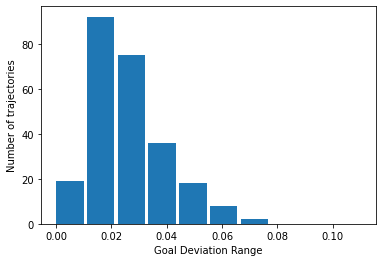

In [116]:
x, y = error_interval_counts(0.0, 0.1, 10, metrics[:, 5])
print (x)
print (y)
plt.bar(x, y, align='edge', width=0.01, linewidth=10.0)
plt.ylabel('Number of trajectories')
plt.xlabel('Goal Deviation Range')
plt.show()

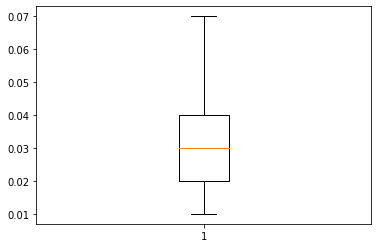

In [124]:
plt.boxplot(metrics[:, 5])
plt.show()
plt.close()

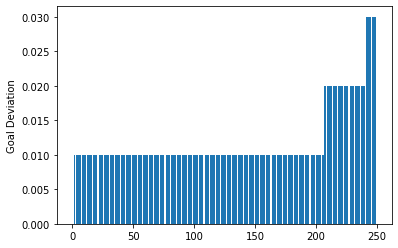

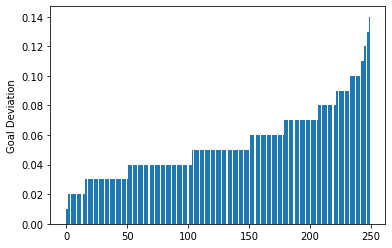

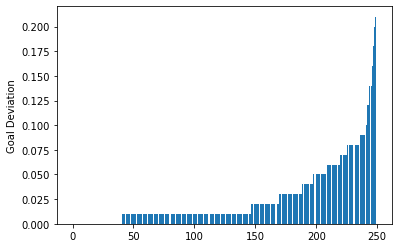

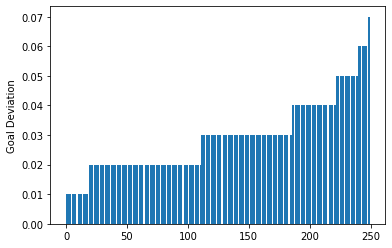

In [120]:
for i in range(2, 6):
    plt.bar(range(len(metrics)), np.sort(metrics[:, i]))
    plt.ylabel('Goal Deviation')
    plt.show()
    plt.close()